In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pdb
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

import h5py

import time
import random
import string
from datetime import datetime

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.datasets import MNIST
import torch.optim as optim
import os

from mie2c.e2c import E2C, compute_loss
from mie2c.ball_model import (get_ball_encoder, get_ball_decoder,
    get_ball_transition, get_ball_linear_transition, get_ball_pwa_transition)

### Method to create (3,32,32) tensor

In [3]:
def create_img(X, pos_bounds, radius=0.5, W=32):
    x, y, vx, vy = X

    # Check if center of ball outside image frame
    if x < pos_bounds[0] or x > pos_bounds[1]:
        return None
    elif y < pos_bounds[0] or y > pos_bounds[1]:
        return None

    x_px = int(round(W * x / posbounds[1]))
    y_px = int(round(W * y / posbounds[1]))
    r_px = int(round(radius / pos_bounds[1] * W))

    # Check if perimeter of ball outside image frame
    if x_px+r_px > W or x_px-r_px < 0:
        return None
    elif y_px+r_px > W or y_px-r_px < 0:
        return None

    img = np.ones((3,W,W))
    yy,xx = np.mgrid[:W, :W]
    circle = (xx-x_px)**2 + (yy-y_px)**2
    img[:, circle < r_px**2] = 0.

    th = np.arctan2(vy,vx)
    for rr in range(r_px):
        img[0,int(y_px+rr*np.sin(th)), int(x_px+rr*np.cos(th))] = 1.

    return img

### PWA single integrator kinematics

In [4]:
def step(x0, Ak, add_noise=False):
    update = Ak @ x0
    if add_noise:
        mn = np.array([0.1, 0.1])
        cov = np.diag([0.05, 0.05])
        frzn = stats.multivariate_normal(mn, cov)
        update += frzn.rvs(1)
    return update

### Generate training data

In [5]:
n = 4 
dh = 0.05

posbounds = np.array([0,4]) # 4x4m square
velmax = 10.

Ak = np.eye(n)
Ak[0:int(n/2), int(n/2):] = dh * np.eye(int(n/2))

np.random.seed(12)

W = 32

# Training data
NUM_DATA = 500

X = np.zeros((NUM_DATA,3,W,W))
X_next = np.zeros((NUM_DATA,3,W,W))

count = 0
while count < NUM_DATA:
    x0 = np.hstack((posbounds[1] * np.random.rand(2), velmax*np.ones(2)))

    img = create_img(x0, posbounds)
    if img is None:
        continue

    x0_new = step(x0, Ak)
    img_new = create_img(x0_new, posbounds)
    if img_new is None:
        continue

    X[count,:,:,:] = img
    X_next[count,:,:,:] = img_new

    count += 1

# Test data
NUM_TEST = 100

X_test = np.zeros((NUM_TEST,3,W,W))
X_next_test = np.zeros((NUM_TEST,3,W,W))

count = 0
while count < NUM_TEST:
    x0 = np.hstack((posbounds[1] * np.random.rand(2), velmax*np.ones(2)))

    img = create_img(x0, posbounds)
    if img is None:
        continue

    x0_new = step(x0, Ak)
    img_new = create_img(x0_new, posbounds)
    if img_new is None:
        continue

    X_test[count,:,:,:] = img
    X_next_test[count,:,:,:] = img_new

    count += 1

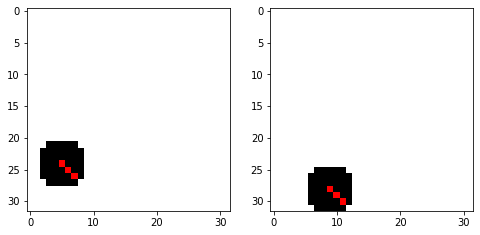

In [6]:
idx = 0
img, img_next = X[idx], X_next[idx]

fig = plt.figure(figsize=(8,8))

fig.add_subplot(1,2,1)
plt.imshow(img.transpose(1,2,0))

fig.add_subplot(1,2,2)
plt.imshow(img_next.transpose(1,2,0))

In [7]:
dim_in = X[0].shape
dim_z = 6
dim_u = 0

# Training method

In [8]:
def train_vae(model, X, X_next, model_name, verbose=True):
    if not os.path.exists('pytorch'):
        os.makedirs('pytorch')
    fn_pt_model = 'pytorch/{}.pt'.format(model_name)
    dim_u = model.trans.dim_u

    # training parameters
    TRAINING_ITERATIONS = int(2500)
    BATCH_SIZE = int(32)
    CHECKPOINT_AFTER = int(2500)
    SAVEPOINT_AFTER = int(5000)
    TEST_BATCH_SIZE = int(32)
    KL_LAMBDA = .25

    dataset = torch.utils.data.TensorDataset(torch.tensor(X).float(), \
                                             torch.tensor(X_next).float())
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    optimizer = optim.Adam(model.parameters())

    itr = 0
    for epoch in range(TRAINING_ITERATIONS):
        iter_count = 0
        for x, x_next in dataloader:
            optimizer.zero_grad()
            action = torch.empty(NUM_DATA, dim_u)

            model(x, action, x_next)
            elbo_loss, kl_loss = compute_loss(model.x_dec, model.x_next_dec, model.x_next_pred_dec,
                                              x, x_next,
                                              model.Qz, model.Qz_next, model.Qz_next_pred)
            loss = elbo_loss + KL_LAMBDA * kl_loss

            loss.backward()
            optimizer.step()

            if itr % CHECKPOINT_AFTER == 0:
                print('Avg. loss: {}'.format(loss.item()))

            if itr % SAVEPOINT_AFTER == 0:
                torch.save(model.state_dict(), fn_pt_model)

            iter_count += 1
            itr += 1

# E2C Transition

In [9]:
encoder = get_ball_encoder(dim_in, dim_z)
e2c_transition = get_ball_transition(dim_z, dim_u)
decoder = get_ball_decoder(dim_z, dim_in)

fn_e2c = 'model_e2c'
model_e2c = E2C(encoder, e2c_transition, decoder)

if os.path.exists('pytorch/{}.pt'.format(fn_e2c)):
    model_e2c.load_state_dict(torch.load('pytorch/{}.pt'.format(fn_e2c)))

In [10]:
train_vae(model_e2c, X, X_next, fn_e2c, verbose=True)

Avg. loss: 113.76451850102052
Avg. loss: 103.29700051230672
Avg. loss: 91.11028184742275
Avg. loss: 85.26539619204436


# Linear Transition

In [11]:
use_low_rank = True  # True if A = I + r*v^T

encoder = get_ball_encoder(dim_in, dim_z)
lin_transition = get_ball_linear_transition(dim_z, dim_u, low_rank=use_low_rank)
decoder = get_ball_decoder(dim_z, dim_in) 

fn_lin = 'model_lin'
model_lin = E2C(encoder, lin_transition, decoder)

if os.path.exists('pytorch/{}.pt'.format(fn_lin)):
    model_lin.load_state_dict(torch.load('pytorch/{}.pt'.format(fn_lin)))

In [12]:
train_vae(model_lin, X, X_next, fn_lin, verbose=True)

Avg. loss: 116.28622857260598
Avg. loss: 92.90040755737856
Avg. loss: 56.35104754830703
Avg. loss: 40.65901443385218


# PWA Transition

In [13]:
use_low_rank = False  # True if A = I + r*v^T
num_modes = 2

encoder = get_ball_encoder(dim_in, dim_z)
pwa_transition = get_ball_pwa_transition(num_modes, dim_z, dim_u, low_rank=use_low_rank)
decoder = get_ball_decoder(dim_z, dim_in) 

fn_pwa = 'model_pwa'
model_pwa = E2C(encoder, pwa_transition, decoder)

if os.path.exists('pytorch/{}.pt'.format(fn_pwa)):
    model_pwa.load_state_dict(torch.load('pytorch/{}.pt'.format(fn_pwa)))

In [14]:
train_vae(model_pwa, X, X_next, fn_pwa, verbose=True)

Avg. loss: 850.2944749346916
Avg. loss: 125.79966340708206
Avg. loss: 122.24094807820256
Avg. loss: 116.18410255832183


# Evaluation

In [15]:
x_pred_e2c = model_e2c.predict(torch.tensor(X_test).float(), torch.empty(NUM_TEST,1).float())
l2_err_e2c = (x_pred_e2c - torch.tensor(X_test)).pow(2).sum(axis=1).sum(axis=1).sum(axis=1).pow(0.5).detach().cpu().numpy()

x_pred_lin = model_lin.predict(torch.tensor(X_test).float(), torch.empty(NUM_TEST,1).float())
l2_err_lin = (x_pred_lin - torch.tensor(X_test)).pow(2).sum(axis=1).sum(axis=1).sum(axis=1).pow(0.5).detach().cpu().numpy()

x_pred_pwa = model_pwa.predict(torch.tensor(X_test).float(), torch.empty(NUM_TEST,1).float())
l2_err_pwa = (x_pred_pwa - torch.tensor(X_test)).pow(2).sum(axis=1).sum(axis=1).sum(axis=1).pow(0.5).detach().cpu().numpy()

In [16]:
import seaborn as sns
sns.set(font_scale=2., font="serif", style="whitegrid")

import pandas as pd

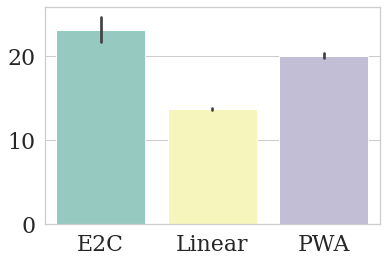

In [17]:
results = {'E2C':l2_err_e2c, 'Linear':l2_err_lin, 'PWA':l2_err_pwa}
results = pd.DataFrame(results)

ax1 = sns.barplot(data=results, palette="Set3")